In [1]:
from pcb_envs import MultiPathGridEnv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import matplotlib.pyplot as plt
from dqn_agent import DQNAgent
from agent_trainer import QLearner
from IPython.display import display, clear_output
import csv 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

## Env 1

In [4]:
n_agents = 1
grid_size = [15,10]
obstacles = [(3,3),(6,2), (6,3), (9,4), (9,3), (10,4), (8,9), (8,8)]
starts = [(13,8)]
goals = [(1,1)] # orig: (2,1) 
to_train = True 

In [5]:
env1 = MultiPathGridEnv(obstacles, starts, goals, grid_size=grid_size, obs_size=[40,40], agents_n=n_agents, train=to_train) 

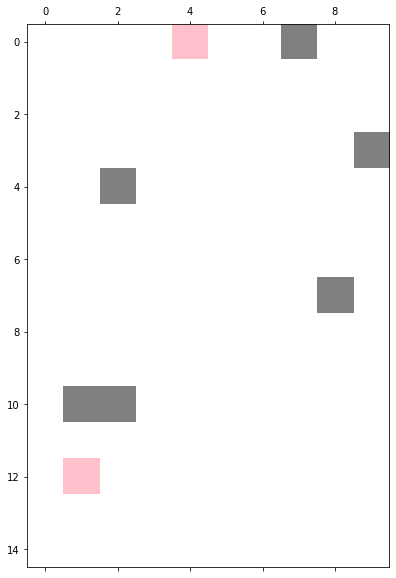

In [6]:
env1.render()

# DQN

In [7]:
state_dim = grid_size[0]*grid_size[1]
action_dim = 8

### Training

In [8]:
dqn_agent = DQNAgent(action_dim, device)
reward_sums_list = []
epsilon_history = []

In [9]:
def train_agent(agent):
    N = 100000
    max_time_steps = 3000
    epsilon = 0.4
    decay = 0.9999
    min_epsilon = 0.1
    for episode in range(N):
        reward_sum = 0
        state = env1.reset()[0] # Indent into 0 for now and elsewhere :-) 
        epsilon = max(min_epsilon, epsilon*decay)
        epsilon_history.append(epsilon)
        for i in range(max_time_steps):
            chosen_actions = []
            t_state = (torch.from_numpy(state[0]).reshape(1,1,grid_size[0],grid_size[1]).float().to(device),torch.Tensor([state[1]]).to(device))
            action = agent.epsilon_greedy_action(t_state, epsilon)
            if type(action) is not list:
                action = [action]
            next_state, reward, terminal = env1.step(action)
            next_state = next_state[0]
            buff_next_state = (next_state[0].reshape(1,grid_size[0],grid_size[1]), next_state[1])
            buff_state = (state[0].reshape(1,grid_size[0],grid_size[1]), state[1])
            reward_sum += reward[0]
            agent.memory.add_to_buffer((buff_state, buff_next_state, action, [reward], [terminal]))
            state = next_state
            #env1.render()
            if terminal:
                #clear_output(wait=False)
                #display('Current episode: ' + str(episode))
                reward_sums_list.append(reward_sum)
                reward_sum = 0
                break
        if episode !=0:
            agent.update(5)

In [10]:
train_agent(dqn_agent)

KeyboardInterrupt: 

## Visualise training 

In [ ]:
# Save it too... 
wtr = csv.writer(open ('learning_history.csv', 'w'), delimiter=',', lineterminator='\n')
for x in reward_sums_list : wtr.writerow ([x]) 

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(8)
color = 'tab:red'
ax1.set_xlabel('no. of episodes')
ax1.set_ylabel('Total reward', color=color)
cumsum_vec = np.cumsum(np.insert(reward_sums_list, 0, 0)) 
ma_vec = (cumsum_vec[100:] - cumsum_vec[:-100]) / 100 # <<-- 100 instead of 5
ax1.plot(range(0,len(ma_vec)), ma_vec, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('epsilon value', color=color)
cumsum_vec_e = np.cumsum(np.insert(epsilon_history, 0, 0)) 
ma_vec_e = (cumsum_vec_e[100:] - cumsum_vec_e[:-100]) / 100
ax2.plot(range(0,len(ma_vec_e)), ma_vec_e, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
print("Max reward sum received: ", np.max(reward_sums_list))

## Learnt Policy 

In [ ]:
def test_policy(agent):
    max_time_steps = 5000
    reward_sum = 0
    state = env1.reset()[0]
    for i in range(max_time_steps):
        t_state = (torch.from_numpy(state[0]).reshape(1,1,grid_size[0],grid_size[1]).float().to(device),torch.Tensor([state[1]]).to(device))
        action = agent.policy_action(t_state)
        next_state, reward, terminal = env1.step([action])
        next_state = next_state[0]
        reward_sum += reward[0]
        state = next_state
        env1.render()
        if terminal:
            state = env1.reset()[0]
            reward_sum = 0
            break
    print("Reward sum is: ", reward_sum)

In [ ]:
test_policy(dqn_agent)

In [ ]:
state

## Interpratability test 

In [ ]:
env1.reset()
env1.step([0])
state = env1.step([0])[0][0]
t_state = (torch.from_numpy(state[0]).reshape(1,1,grid_size[0],grid_size[1]).float().to(device),torch.Tensor([state[1]]).to(device))

In [ ]:
state

In [ ]:
dqn_agent.qnet(t_state)

In [ ]:
env1.render()

## Save model parameters 

In [ ]:
!ls

In [ ]:
torch.save(dqn_agent.qnet.state_dict(), 'models/concat-mlp.pt')

## Generalisation test 

In [ ]:
env1_mod1 = MultiPathBoardEnv(obstacles, starts, [(7,4)], grid_size=grid_size, agents_n=n_agents) 
reward_sums_list = []

In [ ]:
env1_mod1.render()

In [ ]:
def run_agent():
    N = 2
    max_time_steps = 1000
    for episode in range(N):
        reward_sum = 0
        state = env1_mod1.reset().flatten()
        for i in range(max_time_steps):
            chosen_actions = []
            action = dqn_agent.policy_action(torch.from_numpy(state.flatten()).float())
            next_state, reward, terminal = env1_mod1.step([action])
            next_state = next_state.flatten() 
            reward_sum += reward[0]
            state = next_state
            env1_mod1.render()
            if terminal:
                time.sleep(0.2)
                reward_sums_list.append(reward_sum)
                state = env1_mod1.reset().flatten()
                reward_sum = 0
                break

In [ ]:
# GENERALISATION TEST TO BE COMPLETED!! :) 

In [13]:
np.random.normal(0, 0.1, 1)

array([0.01316321])